# Assignment
<b>Date</b>: Dec 5th, 2022<br>
<b>Name</b>: Elaheh Ekhveh <br>


For this assignment we want to analyze the crime data in Toronto in two steps. The data is the API extracted from [here](https://data.torontopolice.on.ca/)

* we will explore point pattern analysie, density of crimes and compute global Moran’s I
* we will explore other datasets such as: economic, housing of the neighborhood to identify any spatial dependence



<b> Question: </b>
<p> <b> Part A-1</b></p>

1. Are the crimes clustered? Is there Central Tendency? Create a density map showing the local density (quadrat or kernel method may be used) and describe the results (< 100 words).


First we need to import libraries:
* analysis: pandas, geopandas, numpy, requests, json, libpysal, pointpats, esda
* visualization: matplot, seaborn, geoplot, contextily, splot.esda

In [104]:
#analysis
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
import requests
import json
import libpysal
from pointpats import PointPattern
from pointpats.centrography import mean_center, manhattan_median, euclidean_median
from pointpats import distance_statistics, QStatistic,random, PointPattern
import esda
from esda.moran import Moran,Moran_Local

#visualization
import matplotlib.pyplot as plt
import seaborn
import contextily
import geoplot as gplt
from splot.esda import moran_scatterplot, lisa_cluster


for city of Toronto the API from Toronto Public Service Public Safety Data Portal has been extracted and parsed:<br>
the data is for <b> 2020-2021 </b> and the major crime indicator (MCI) is converted to <b>Assualt</b>

In [2]:
URL="https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/Assault/FeatureServer/0/query?f=json&where=(reportedyear%20%3E%3D%202021%20AND%20reportedyear%20%3C%3D%202022)&outFields=*"
response_API=requests.get(URL)
data=response_API.text
parse_json=json.loads(data)



Now we try to extract the elements we need for this assignment from the JSON file:

In [3]:
mci_category=[]
occurrencemonth=[]
reportedday=[]
occurrencedayofyear=[]
Neighbourhood=[]
Division=[]
occurrencedate=[]
Latitude=[]
Longitude=[]
location_type=[]


for feature in parse_json['features']:
    mci_category.append(feature['attributes']['mci_category'])
    occurrencemonth.append(feature['attributes']['occurrencemonth'])
    reportedday.append(feature['attributes']['reportedday'])
    occurrencedayofyear.append(feature['attributes']['occurrencedayofyear'])
    Neighbourhood.append(feature['attributes']['Neighbourhood'])
    Division.append(feature['attributes']['Division'])
    occurrencedate.append(feature['attributes']['occurrencedate'])
    Latitude.append(feature['attributes']['Latitude'])
    Longitude.append(feature['attributes']['Longitude'])
    location_type.append(feature['attributes']['location_type'])


Then we convert json format to Dataframe using Pandas:

In [4]:
df=gpd.GeoDataFrame({"mci_category":mci_category,"occurrencemonth":occurrencemonth,"reportedday":reportedday,
"Division": Division,"occurrencedayofyear":occurrencedayofyear,"Neighbourhood":Neighbourhood,
"occurrencedate":occurrencedate,"location_type":location_type,"Longitude":Longitude, "Latitude":Latitude})

Here, we filter some of the data:
* first the time of the crime occured is in UNIX format we convert it to Date format
* second, some of the data are not located coorectly, we filter them out

In [26]:
df['occurrencedate']=pd.to_datetime(df['occurrencedate'],unit='ms')
df=df[df["Longitude"] !=0]

df.head()
#df.to_csv('/Users/eliekhveh/Desktop/file_name.csv')


,mci_category,occurrencemonth,reportedday,Division,occurrencedayofyear,Neighbourhood,occurrencedate,location_type,Longitude,Latitude,geometry
0,Assault,January,3,D43,3,Woburn,2021-01-03 05:00:00,"Parking Lots (Apt., Commercial Or Non-Commercial)",-79.233849,43.781745,POINT (-79.23385 43.78175)
1,Assault,January,9,D31,9,Black Creek,2021-01-09 05:00:00,"Single Home, House (Attach Garage, Cottage, Mo...",-79.520561,43.761434,POINT (-79.52056 43.76143)
2,Assault,January,7,D51,7,Moss Park,2021-01-07 05:00:00,"Apartment (Rooming House, Condo)",-79.370083,43.656162,POINT (-79.37008 43.65616)
3,Assault,January,12,D33,11,Victoria Village,2021-01-11 05:00:00,"Apartment (Rooming House, Condo)",-79.306415,43.730000,POINT (-79.30641 43.73000)
4,Assault,January,1,D41,1,Kennedy Park,2021-01-01 05:00:00,"Single Home, House (Attach Garage, Cottage, Mo...",-79.252606,43.734455,POINT (-79.25261 43.73446)


<b>Pointpats</b> is a package to support the statistical analysis of planar point patterns. <br>
To find if there is any <b>Central Tendecy</b> of point patterns we need to use <b> Centrography </b> analysis.<br>
In this assignment we use <b>Mean_Center, Manhattan_Median, and Euclidean_Median</b> functions. <br>

In [21]:
#filtering data
second_df=gpd.GeoDataFrame({"Longitude":Longitude, "Latitude":Latitude})
new_df=second_df[second_df["Longitude"] !=0]

# #create a point pattern "pp" from list
pp = PointPattern(new_df) 

Mean Center:[-79.38342826  43.70691971]
Manhattan Median:[-79.38607321  43.69836192]
Euclidean Median:[-79.3873028   43.68427202]


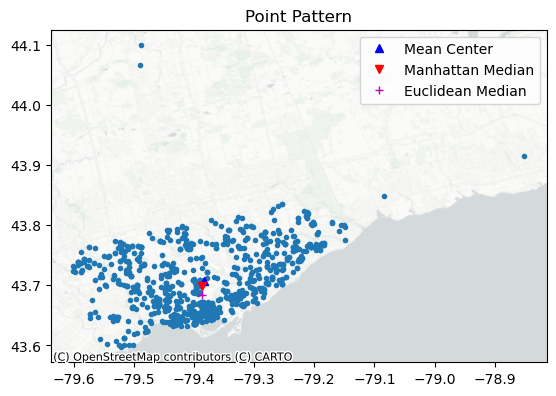

In [7]:
#Mean Center 
mc = mean_center(pp.points)
print(f"Mean Center:{mc}")

#Manhattan Median
mm = manhattan_median(pp.points)
print(f"Manhattan Median:{mm}")

#Euclidean  Median
em = euclidean_median(pp.points)
print(f"Euclidean Median:{em}")

#plot
ax=pp.plot(get_ax=True)
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.plot(mm[0], mm[1], 'rv', label='Manhattan Median')
plt.plot(em[0], em[1], 'm+', label='Euclidean Median')
plt.legend(numpoints=1)


#basemap
contextily.add_basemap(ax, source=contextily.providers.CartoDB.PositronNoLabels, crs="EPSG:4326")

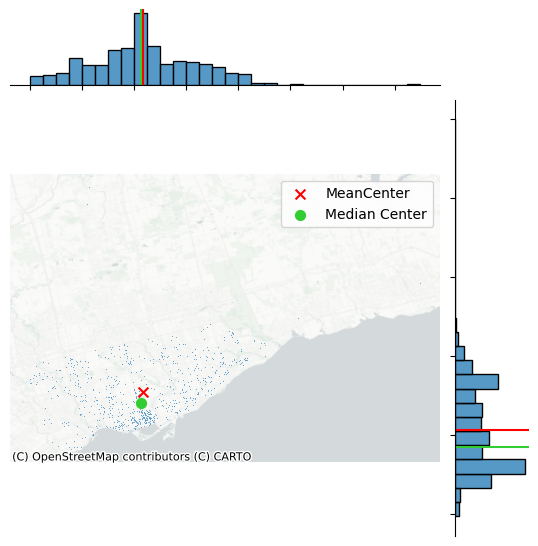

In [8]:
# Generate scatter plot
joint_axes = seaborn.jointplot(
    x="Longitude", y="Latitude", data=df, s=0.5)

# Add mean point and marginal lines
joint_axes.ax_joint.scatter(*mc, color="red", marker="x", s=50, label="MeanCenter")
joint_axes.ax_marg_x.axvline(mc[0], color="red") 
joint_axes.ax_marg_y.axhline(mc[1], color="red") 
# Add median point and marginal lines 
joint_axes.ax_joint.scatter(*em,color="limegreen",marker="o",s=50,label="Median Center")
joint_axes.ax_marg_x.axvline(em[0], color="limegreen") 
joint_axes.ax_marg_y.axhline(em[1], color="limegreen")

# Legend
joint_axes.ax_joint.legend()

#basemap
contextily.add_basemap(joint_axes.ax_joint, source=contextily.providers.CartoDB.PositronNoLabels, crs="EPSG:4326")

# Clean axes 
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

Here we create a density map showing the local density which is kernel method.

/var/folders/rj/m2jqdxtj33l828hsrp0r_ych0000gn/T/ipykernel_14086/3688724716.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(


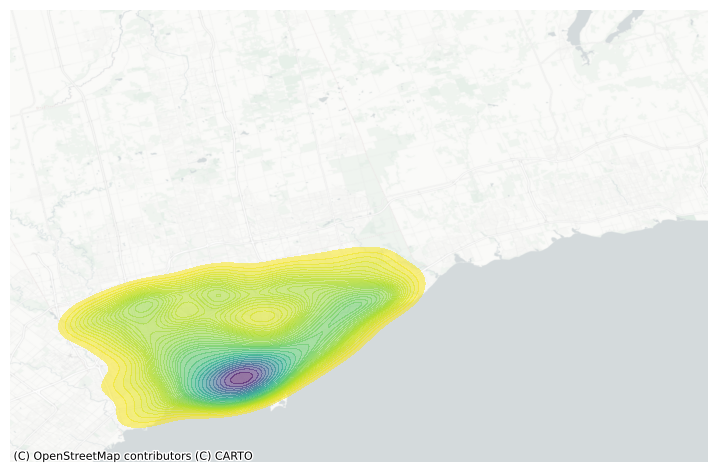

In [9]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# KDE 
seaborn.kdeplot(
x= df["Longitude"],
y= df["Latitude"], 
n_levels=40, 
shade=True,
alpha=0.55, 
cmap="viridis_r")

# Add basemap
contextily.add_basemap(ax, source=contextily.providers.CartoDB.PositronNoLabels, crs="EPSG:4326")

# Remove axes
ax.set_axis_off()

<b> Answer: </b>
<p> <b> Part A-1</b></p>
<p>If we want to help to prevent Assault crime occurrence in Toronto, we need to take centeral feature like Mean, Median to make better decision. We see that most of them are clustered in a particular area, and we can determine the most possible accebile location of occurring the mentioned crime and decide to prevent that. I believe that Median is better central tendacy measurement in our case, so that most of the crimes clustered at the bottom of the horizontal axis of the median point.<br>

we also can use Seaborn informative statistical graphics, which is "jointplot", and we can see dots tend to be concentrated in the center of the area in a pattern. However the density of points is so large. That's why we look for density measurement like KDE which is a data smoothing technique. Using KDE, we see the majority of crimes localized areas.

<b> Question: </b>
<p> <b> Part A-2</b></p>

2. Are there spatial outliers or trends in the data you’ve selected? Discuss (include any tests run, figures, and maps generated) (200 - 400 words).

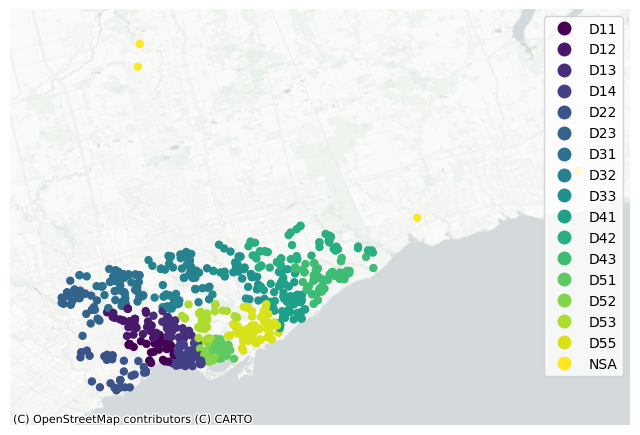

In [48]:
#geodataframe
gdf=gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]))

#Division
ax=gplt.pointplot(gdf, hue="Division", legend=True)

# Add basemap
contextily.add_basemap(ax, source=contextily.providers.CartoDB.PositronNoLabels, crs="EPSG:4326")


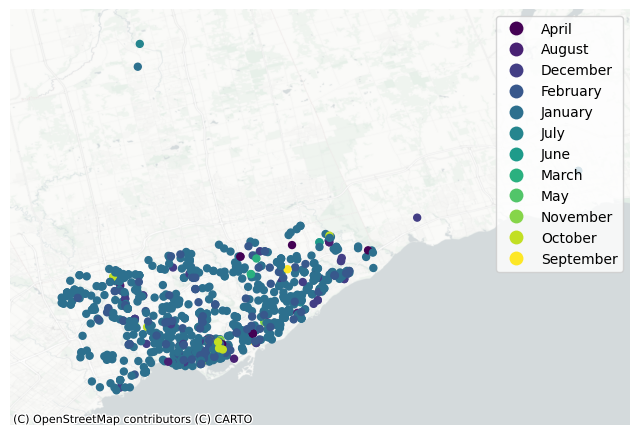

In [49]:
#occurrence_month
ax=gplt.pointplot(gdf, hue="occurrencemonth",legend=True)

# Add basemap
contextily.add_basemap(ax, source=contextily.providers.CartoDB.PositronNoLabels, crs="EPSG:4326")

,geometry,Neighbourhood
Division,,
D11,"MULTIPOINT (-79.50346 43.66294, -79.50345 43.6...",45
D12,"MULTIPOINT (-79.53483 43.71042, -79.52672 43.7...",42
D13,"MULTIPOINT (-79.46753 43.70542, -79.45471 43.6...",33
D14,"MULTIPOINT (-79.44092 43.63974, -79.43993 43.6...",77
D22,"MULTIPOINT (-79.57351 43.64510, -79.57218 43.6...",39


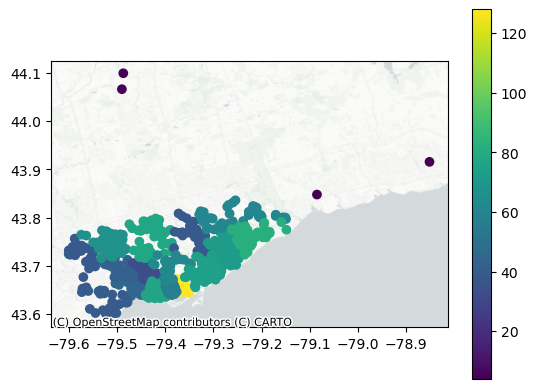

In [87]:
#dissolving by division and count of neighbourhoods as an aggregate function

division_gp=gdf.dissolve(by="Division", aggfunc={"Neighbourhood":"count"})
ax=division_gp.plot(column="Neighbourhood",  legend=True)

# Add basemap
contextily.add_basemap(ax, source=contextily.providers.CartoDB.PositronNoLabels, crs="EPSG:4326")

division_gp.head()


/Users/eliekhveh/opt/anaconda3/lib/python3.9/site-packages/geoplot/geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


<AxesSubplot:>

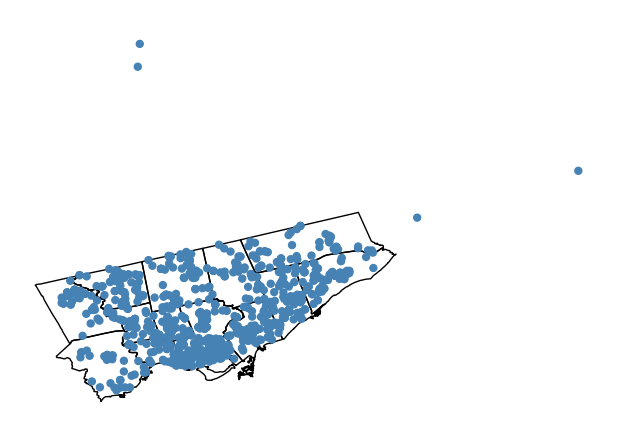

In [105]:
#adding the shapefile of police divisons
gdf_division=gpd.read_file("/Users/eliekhveh/Desktop/py_scripts/linear_regression/Police_Divisions/Police_Divisions.shp")
gdf_division=gdf_division.to_crs("EPSG:4326")
ax = gplt.polyplot(gdf_division)
gplt.pointplot(gdf, ax=ax)

<b> Answer: </b>
<p> <b> Part A-2 </b></p>


<p>Outliers are the data points that lie far away from the rest of the data values, in the graph we can see outliers in the scatterplot both in point pattern plot and seaborn plot. sometimes it is more meaningful to look for local outlier which means a point that is farther away from its neighbors, outliers can affect on the mean for statistical analysis.<p>

<p> We also compared several different ways to visualize crime data and show the patterns. First, we changed the hue of a crimes' plotted point based on that city’s <b> Division </b>, and also added a legend to decode the meaning of the different hues. We Found out that some dicision has less crimes, and some of them have huges numbers clustered (Division 41-55), also we see outlier specified in division "NSA". Another hue is based on months of the crimes reported that shows most of the Assualt crimes happened in January and February<p>

<p>Another pattern is based on the new geodataframe that shows the number of crimes in the neighborhoods of each division, we also can see the outliers data. </p>





<b> Question: </b>
<p> <b> Part B-3</b></p>

3. What is the probability that this spatial pattern could have arisen by chance (Moran’s I)? (Include graphs and or text to support your answer.)

moran_index: 0.6126831431497483
p_value: 0.001


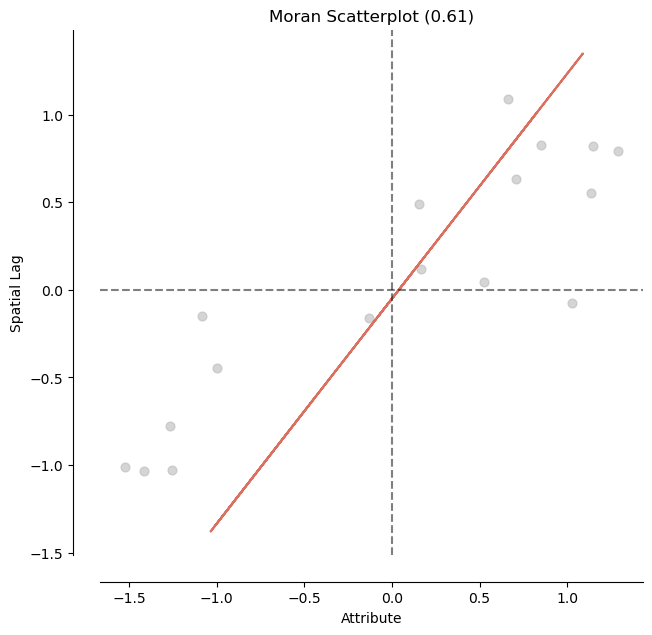

In [88]:
# Generate W from the GeoDataFrame
w = libpysal.weights.distance.KNN.from_dataframe(division_gp, k=5) 

# Row-standardization
w.transform = "R"

#spatial_lag
y=np.log(division_gp["Neighbourhood"])
division_gp["Neighbourhood_lag"] = libpysal.weights.lag_spatial(w, y)

#global_spatial_autocorrelation
m1=esda.Moran(division_gp["Neighbourhood_lag"],w)

print("moran_index:", m1.I)
moran_scatterplot(m1)

#p_value
print("p_value:", m1.p_sim)


In [90]:
#local_spatial_autocorrelation
lisa=esda.Moran_Local(division_gp["Neighbourhood_lag"],w)
division_gp["quadrant"]=lisa.q
division_gp["significant"]=lisa.p_sim<0.05
division_gp.head()

,geometry,Neighbourhood,Neighbourhood_lag,quadrant,significant
Division,,,,,
D11,"MULTIPOINT (-79.50346 43.66294, -79.50345 43.6...",45,3.853379,3,False
D12,"MULTIPOINT (-79.53483 43.71042, -79.52672 43.7...",42,3.758795,3,True
D13,"MULTIPOINT (-79.46753 43.70542, -79.45471 43.6...",33,4.008125,3,False
D14,"MULTIPOINT (-79.44092 43.63974, -79.43993 43.6...",77,4.061537,1,False
D22,"MULTIPOINT (-79.57351 43.64510, -79.57218 43.6...",39,3.804446,3,True


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

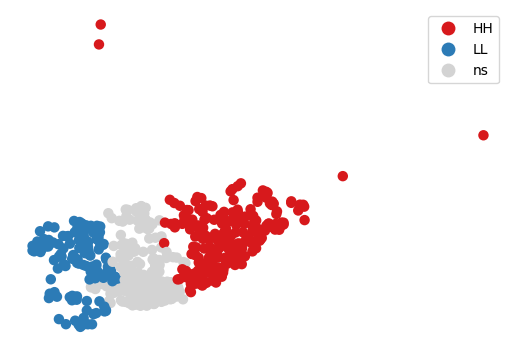

In [53]:
#visualization of hot-spots and cold-spots
lisa_cluster(lisa, division_gp)

<b> Answer: </b>
<p> <b> Part B-1 </b></p>

<p>Previousely we assessed the visualization of the data and the patterns. We found out these data tends to suggest clustering or spatial autocorrelation as the values do appear to be clustered. To confirm this suspicion we can use Global Moran's I.</p>

<p>If Global Moran's I is positive (HH-LL) and the p value is zero, this indicates a strong clustering pattern. so the pattern is not random. If it is negative (HL), we find out dissimilar values cluster together on a map, and the pattern is random. In our data, we see the Moran's I is positive and p-value is almost 0, which shows the non-random pattern.</p>

<p> To calculate Moran's I index, we first used the dissloved crimes by the division. For this purpose, we need a weight matrix. Weight matrix tells us what is the correlation between one geography and any other geography. We also need spatial lag of the particular varibale. the spatial lag is defined by multiplying wight to the particular varibale, which the number of neighbourhoods' crimes in each division.<p>

<p> Another usefull spatial autocorrelatio is local measurement (LISA) that focuses on the relationships between each crime and its surroundings and says us how crimes actually happened in a particular location. In our study area, we can find clusters of low values and clusters of high values. From the above map, it shows if government wants to focus on sending more police forces to those areas, they can concentrate which area. </p>

<b> Question: </b>
<p> <b> Part B-2</b></p>

What are some other factors that might influence the location of these types of crimes? Use plots or graphs as necessary to support your response.

In [73]:
#Toronto-economics
df_economics= pd.read_excel('/Users/eliekhveh/Desktop/py_scripts/linear_regression/wellbeing-toronto-economics.xlsx')

#neighbourhood dataframe of the gdf
neighbourhood_gp=gdf[["geometry", "Division","Neighbourhood"]]
neighbourhood_gp=neighbourhood_gp.dissolve(by="Neighbourhood")

#merging two dataframes
df_join= pd.merge(df_economics,neighbourhood_gp, how='inner', on='Neighbourhood' )
df_join.head()


,Neighbourhood,Neighbourhood Id,Businesses,Child Care Spaces,Debt Risk Score,Home Prices,Local Employment,Social Assistance Recipients,geometry,Division
0,West Humber-Clairville,1,2463,195,719,317508,58271,2912,"MULTIPOINT (-79.60072 43.72416, -79.60070 43.7...",D23
1,Mount Olive-Silverstone-Jamestown,2,271,60,687,251119,3244,6561,"MULTIPOINT (-79.59278 43.73908, -79.58831 43.7...",D23
2,Thistletown-Beaumond Heights,3,217,25,718,414216,1311,1276,"MULTIPOINT (-79.57378 43.74172, -79.56655 43.7...",D23
3,Rexdale-Kipling,4,144,75,721,392271,1178,1323,"MULTIPOINT (-79.57462 43.73082, -79.55683 43.7...",D23
4,Elms-Old Rexdale,5,67,60,692,233832,903,1683,"MULTIPOINT (-79.55508 43.71510, -79.55384 43.7...",D23


<AxesSubplot:xlabel='Businesses', ylabel='Division'>

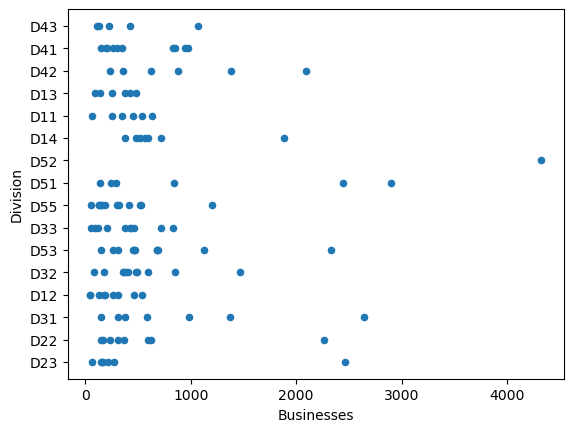

In [93]:
df_join.plot.scatter(x= "Businesses", y="Division")


Previously we found out Assualt crimes happened more in Division 41 to 55. Here we used Toronto Economoics data and comparing different economics indicitors to find out if there is any pattern between them. First, we compared number of Businesses, and here we can see that in those mentioned divisions we see more Businesses in neighbourhoods. 

<AxesSubplot:xlabel='Social Assistance Recipients', ylabel='Division'>

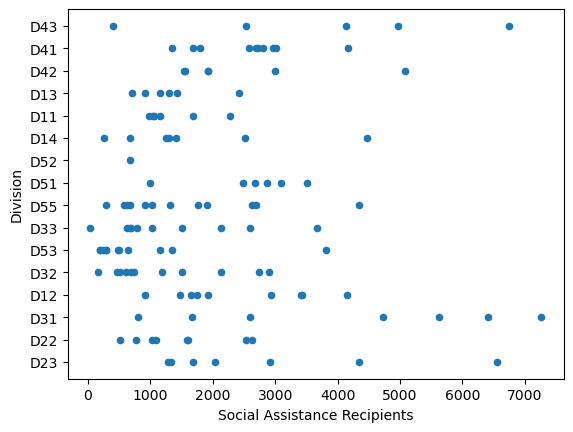

In [97]:
df_join.plot.scatter(x= "Social Assistance Recipients", y="Division")

Also in those divisions most social assistance were provided, which is better news. 

In [100]:
df_housing= pd.read_excel('/Users/eliekhveh/Desktop/py_scripts/linear_regression/wellbeing-toronto-housing.xlsx')

#merging two dataframes
df2_join= pd.merge(df_housing,neighbourhood_gp, how='inner', on='Neighbourhood' )
df2_join.head()


,Neighbourhood,Neighbourhood Id,Home Prices,Mid-Century Highrise Households,Mid-Century Highrise Population,Percent Mid-Century Highrise Households,Percent Mid-Century Highrise Population,Rent Bank Applicants,Social Housing Turnover,Social Housing Units,Social Housing Waiting List,geometry,Division
0,West Humber-Clairville,1,317508,690,1810,6.8,5.3,38,0.312500,952,557,"MULTIPOINT (-79.60072 43.72416, -79.60070 43.7...",D23
1,Mount Olive-Silverstone-Jamestown,2,251119,4110,13395,42.9,40.9,41,7.000000,1146,1049,"MULTIPOINT (-79.59278 43.73908, -79.58831 43.7...",D23
2,Thistletown-Beaumond Heights,3,414216,430,1260,13.4,12.4,7,1.333333,447,270,"MULTIPOINT (-79.57378 43.74172, -79.56655 43.7...",D23
3,Rexdale-Kipling,4,392271,600,1050,15.2,10.0,19,4.200000,432,186,"MULTIPOINT (-79.57462 43.73082, -79.55683 43.7...",D23
4,Elms-Old Rexdale,5,233832,870,2305,27.3,24.1,14,1.000000,463,239,"MULTIPOINT (-79.55508 43.71510, -79.55384 43.7...",D23


<AxesSubplot:xlabel='Social Housing Waiting List', ylabel='Division'>

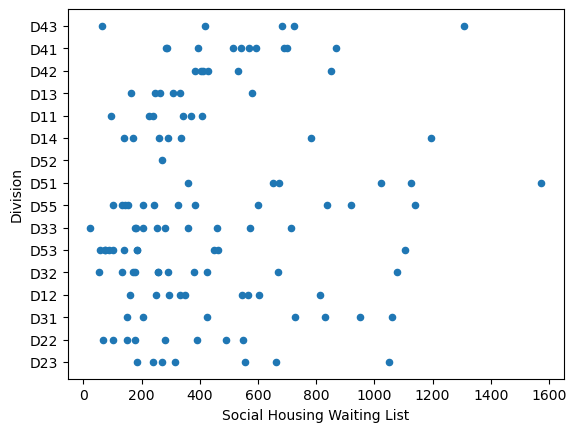

In [103]:
df2_join.plot.scatter(x= "Social Housing Waiting List", y="Division")

Another dataframe is Toronto Housing. Overall, it shows the waiting for housing is more demanded in those divisions, which migh be the reason of Assualt.